In [225]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from datetime import datetime
from sklearn.metrics import accuracy_score
import json
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MultiLabelBinarizer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from collections import Counter
from sklearn.preprocessing import LabelEncoder, scale
from sklearn.datasets import load_boston
from sklearn.metrics import r2_score
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix

import torch.utils.data
from sklearn.model_selection import train_test_split
import xgboost as xgb

import torch
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

In [226]:
def show_heatmap(dataset, k=0, min_val_corr = -0.001, target=None):
    corrmat = dataset.corr()
    sns.set(font_scale=0.75)
    f, ax = plt.subplots(figsize=(15, 15))
    
    if k==0:
        k = dataset.shape[0]
        
    if target != None:
        ser_corr = corrmat.nlargest(k, target)[target]
        cols = ser_corr.index
        cm = np.corrcoef(train[cols].values.T)
        sns.heatmap(cm, cbar=True, annot=True, square=True, vmax=.8, fmt='.2f', yticklabels=cols.values, xticklabels=cols.values)
    else:
        sns.heatmap(corrmat, cbar=True, annot=True, square=True, vmax=.8, fmt='.2f')    
    
    plt.show()

In [227]:
train_csv = pd.read_csv("fact_call_details_2.csv", keep_default_na=False)
#test_csv = pd.read_csv("Dataset/test.csv", keep_default_na=False)

In [228]:
def preprocess_data(dataset):
    #dataset['origination_month'] = dataset["origination_date"].apply(originationMonth)
    #dataset['origination_day'] = dataset["origination_date"].apply(originationDay)
    #dataset['first_payment_month'] = dataset["first_payment_date"].apply(FirstpayMonth)
    #dataset['first_payment_day'] = dataset["first_payment_date"].apply(FirstpayDay)
    #dataset['first_payment_day_from_origin'] = dataset[['origination_day','first_payment_day']].apply(originFirstPayDif, axis=1)
    
    #dataset['co-borrower_credit_score'] = dataset['co-borrower_credit_score'].mask(dataset['co-borrower_credit_score'] == 0,dataset['co-borrower_credit_score'].mean())
    dataset = dataset.drop(['ucid'],axis=1)
    dataset = dataset.drop(['unique_id'],axis=1)
    dataset = dataset.drop(['server_ip'],axis=1)
    dataset = dataset.drop(['recordingfileurl'],axis=1)
    dataset = dataset.drop(['screenfileurl'],axis=1)
    dataset = dataset.drop(['external_id'],axis=1)    
    dataset = dataset.drop(['lead_id'],axis=1)
    dataset = dataset.drop(['list_id'],axis=1)
    
    #dataset['survey_totalscore'] = np.random.randint(1, 100, dataset.shape[0])
    
    return dataset


In [229]:
train = preprocess_data(train_csv.copy())
display(train.head())

,source_pbx,segment,call_date,segstart,segstop,agent_id,extension,duration,queuetime,ringtime,talktime,holdtime,acwtime,skill_campaign,call_disp,direction,calling_pty,outbound_cid,dialed_num,conference,consulttime,da_queued,held,transferred,holdabn,origlogin,agt_released,disposition,called_count,dispivector,client,usr_grp,customer_num
0,13.250.181.75,1,2019-03-04,2019-03-04 14:53:31,2019-03-04 14:53:43,JMC6315,6315,12,0,0,7,0,2,OUTSOURC,1,OUTBOUND,6315,,6017575336,1,0,1,0,1,1,0,1,A,1,0,prequal_fps_pq,CG,6017575336
1,3.0.164.123,1,2019-03-07,2019-03-07 12:58:02,2019-03-07 12:59:24,OG181714,2318,81,0,0,17,0,0,OUTSOURC,1,OUTBOUND,2318,,6318360557,1,0,1,0,1,1,0,1,DCMX,10,0,prequal_fps_pq,CG,6318360557
2,178.63.55.102,1,2019-03-04,2019-03-04 12:07:47,2019-03-04 12:07:54,TOG2474,2474,6,0,0,6,0,2,OUTSOURC,1,OUTBOUND,2474,,4097249297,1,0,1,0,1,1,0,1,A,1,0,prequal_cg,CG,4097249297
3,18.136.115.229,1,2019-03-07,2019-03-07 14:51:20,2019-03-07 14:51:44,MATECH6044,6044,25,0,0,25,0,2,OUTSOURC,1,OUTBOUND,6044,,6159738675,1,0,1,0,1,1,0,1,A,2,0,prequal_fps_pq,CG,6159738675
4,18.136.115.229,1,2019-03-08,2019-03-08 16:37:31,2019-03-08 16:37:37,GOLD1004,4004,5,0,0,5,0,6,GOLD,1,OUTBOUND,4004,,3616950002,1,0,1,0,1,1,0,1,A,8,0,prequal_fps_pq,CG,3616950002


In [230]:
cat = len(train.select_dtypes(include=['object']).columns)
num = len(train.select_dtypes(include=['int64','float64']).columns)
print('Total Features: ', cat, 'categorical', '+', num, 'numerical', '=', cat+num, 'features')
print(train.dtypes)

Total Features:  14 categorical + 19 numerical = 33 features
source_pbx        object
segment            int64
call_date         object
segstart          object
segstop           object
agent_id          object
extension          int64
duration           int64
queuetime          int64
ringtime           int64
talktime           int64
holdtime           int64
acwtime            int64
skill_campaign    object
call_disp          int64
direction         object
calling_pty       object
outbound_cid      object
dialed_num        object
conference         int64
consulttime        int64
da_queued          int64
held               int64
transferred        int64
holdabn            int64
origlogin          int64
agt_released       int64
disposition       object
called_count       int64
dispivector        int64
client            object
usr_grp           object
customer_num      object
dtype: object


In [231]:
train.describe()

,segment,extension,duration,queuetime,ringtime,talktime,holdtime,acwtime,call_disp,conference,consulttime,da_queued,held,transferred,holdabn,origlogin,agt_released,called_count,dispivector
count,20000.0,20000.000000,20000.000000,20000.000000,20000.0,20000.00000,20000.0,20000.000000,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0,20000.000000,20000.0
mean,1.0,6342.897250,25.342500,0.106550,0.0,21.36365,0.0,6.512250,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,3.709750,0.0
std,0.0,9357.774714,50.183537,3.791071,0.0,47.84949,0.0,24.671917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.363208,0.0
min,1.0,2.000000,0.000000,0.000000,0.0,0.00000,0.0,0.000000,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.000000,0.0
25%,1.0,2484.750000,6.000000,0.000000,0.0,5.00000,0.0,2.000000,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,2.000000,0.0
50%,1.0,5636.000000,12.000000,0.000000,0.0,9.00000,0.0,3.000000,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,2.000000,0.0
75%,1.0,6258.000000,27.000000,0.000000,0.0,23.00000,0.0,4.000000,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,5.000000,0.0
max,1.0,101308.000000,1283.000000,210.000000,0.0,1283.00000,0.0,933.000000,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,28.000000,0.0


In [232]:
train.duration.describe()

count    20000.000000
mean        25.342500
std         50.183537
min          0.000000
25%          6.000000
50%         12.000000
75%         27.000000
max       1283.000000
Name: duration, dtype: float64

In [233]:
train_min_duration = train.loc[train['duration'] <= 6.0]
display(train_min_duration.head())
print('Total Record Count {} '.format(train_min_duration['duration'].count()))

,source_pbx,segment,call_date,segstart,segstop,agent_id,extension,duration,queuetime,ringtime,talktime,holdtime,acwtime,skill_campaign,call_disp,direction,calling_pty,outbound_cid,dialed_num,conference,consulttime,da_queued,held,transferred,holdabn,origlogin,agt_released,disposition,called_count,dispivector,client,usr_grp,customer_num
2,178.63.55.102,1,2019-03-04,2019-03-04 12:07:47,2019-03-04 12:07:54,TOG2474,2474,6,0,0,6,0,2,OUTSOURC,1,OUTBOUND,2474,,4097249297,1,0,1,0,1,1,0,1,A,1,0,prequal_cg,CG,4097249297
4,18.136.115.229,1,2019-03-08,2019-03-08 16:37:31,2019-03-08 16:37:37,GOLD1004,4004,5,0,0,5,0,6,GOLD,1,OUTBOUND,4004,,3616950002,1,0,1,0,1,1,0,1,A,8,0,prequal_fps_pq,CG,3616950002
10,13.250.181.75,1,2019-03-07,2019-03-07 14:22:17,2019-03-07 14:22:24,JMC6058,6058,5,0,0,5,0,2,OUTSOURC,1,OUTBOUND,6058,,4073426479,1,0,1,0,1,1,0,1,A,2,0,prequal_fps_pq,CG,4073426479
13,52.77.35.199,1,2019-03-08,2019-03-08 13:01:20,2019-03-08 13:01:27,JMC6249,6249,4,0,0,4,0,3,OUTSOURC,1,OUTBOUND,6249,,7022354533,1,0,1,0,1,1,0,1,A,2,0,prequal_fps_pq,CG,7022354533
20,13.250.181.75,1,2019-03-08,2019-03-08 13:38:13,2019-03-08 13:38:19,EC0008,5008,6,0,0,6,0,1,OUTSOURC,1,OUTBOUND,5008,,2172486869,1,0,1,0,1,1,0,1,A,2,0,prequal_fps_pq,CG,2172486869


Total Record Count 5804 


<p>The audio file with almost nearer to 6 seconds duration may not be a proper call because it may be a voice mail box or not reachable call, even a not interested call</p>
<p>
to pick it up for QA we can do a feature engeneering here by introducing a new field with binary options either take or reject the call
    </p>

In [234]:
train['duration_accepted'] = 0
train.loc[train['duration'] > 6, 'duration_accepted'] = 1


In [235]:
"""
cols = ('direction','skill_campaign')
for c in cols:
    lbl = LabelEncoder()
    lbl.fit(list(train[c].values)) 
    #lbl.fit(list(np.concatenate((train[c].values, test[c].values), axis=None))) 
    train[c] = lbl.transform(list(train[c].values))
    #test[c] = lbl.transform(list(test[c].values))
"""

"\ncols = ('direction','skill_campaign')\nfor c in cols:\n    lbl = LabelEncoder()\n    lbl.fit(list(train[c].values)) \n    #lbl.fit(list(np.concatenate((train[c].values, test[c].values), axis=None))) \n    train[c] = lbl.transform(list(train[c].values))\n    #test[c] = lbl.transform(list(test[c].values))\n"

In [236]:
train.direction.describe()

count        20000
unique           3
top       OUTBOUND
freq         19095
Name: direction, dtype: object

In [237]:
train = pd.get_dummies(train, prefix=['direction', 'skill_campaign'], columns=['direction', 'skill_campaign'])

In [238]:
display(train.head())

,source_pbx,segment,call_date,segstart,segstop,agent_id,extension,duration,queuetime,ringtime,talktime,holdtime,acwtime,call_disp,calling_pty,outbound_cid,dialed_num,conference,consulttime,da_queued,held,transferred,holdabn,origlogin,agt_released,disposition,called_count,dispivector,client,usr_grp,customer_num,duration_accepted,direction_INBOUND,direction_MANUAL,direction_OUTBOUND,skill_campaign_(null),skill_campaign_CDinbound,skill_campaign_CS,skill_campaign_CS_NOREC,skill_campaign_CS_REC,skill_campaign_GOLD,skill_campaign_GOV_CALLS,skill_campaign_LCE_1,skill_campaign_MED_PRO_CALLBACKS,skill_campaign_OUTSOURC
0,13.250.181.75,1,2019-03-04,2019-03-04 14:53:31,2019-03-04 14:53:43,JMC6315,6315,12,0,0,7,0,2,1,6315,,6017575336,1,0,1,0,1,1,0,1,A,1,0,prequal_fps_pq,CG,6017575336,1,0,0,1,0,0,0,0,0,0,0,0,0,1
1,3.0.164.123,1,2019-03-07,2019-03-07 12:58:02,2019-03-07 12:59:24,OG181714,2318,81,0,0,17,0,0,1,2318,,6318360557,1,0,1,0,1,1,0,1,DCMX,10,0,prequal_fps_pq,CG,6318360557,1,0,0,1,0,0,0,0,0,0,0,0,0,1
2,178.63.55.102,1,2019-03-04,2019-03-04 12:07:47,2019-03-04 12:07:54,TOG2474,2474,6,0,0,6,0,2,1,2474,,4097249297,1,0,1,0,1,1,0,1,A,1,0,prequal_cg,CG,4097249297,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3,18.136.115.229,1,2019-03-07,2019-03-07 14:51:20,2019-03-07 14:51:44,MATECH6044,6044,25,0,0,25,0,2,1,6044,,6159738675,1,0,1,0,1,1,0,1,A,2,0,prequal_fps_pq,CG,6159738675,1,0,0,1,0,0,0,0,0,0,0,0,0,1
4,18.136.115.229,1,2019-03-08,2019-03-08 16:37:31,2019-03-08 16:37:37,GOLD1004,4004,5,0,0,5,0,6,1,4004,,3616950002,1,0,1,0,1,1,0,1,A,8,0,prequal_fps_pq,CG,3616950002,0,0,0,1,0,0,0,0,0,1,0,0,0,0


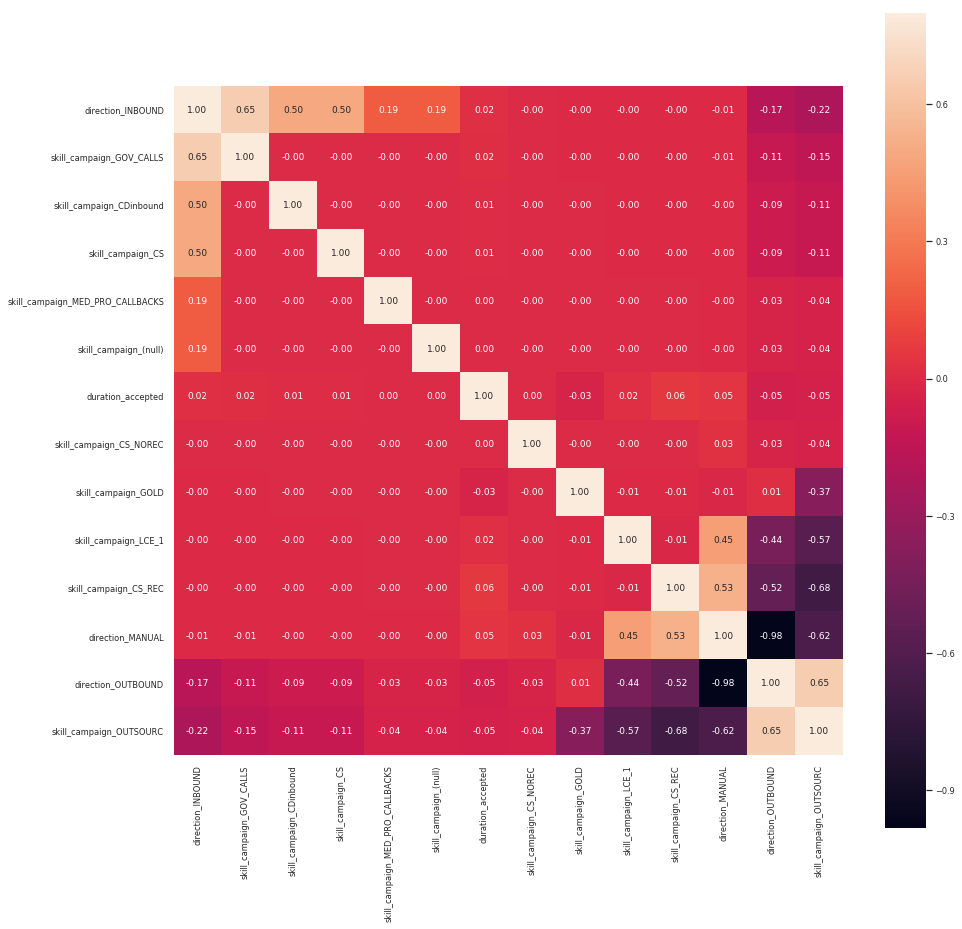

In [239]:
show_heatmap(train.iloc[:, 29:], target="direction_INBOUND")

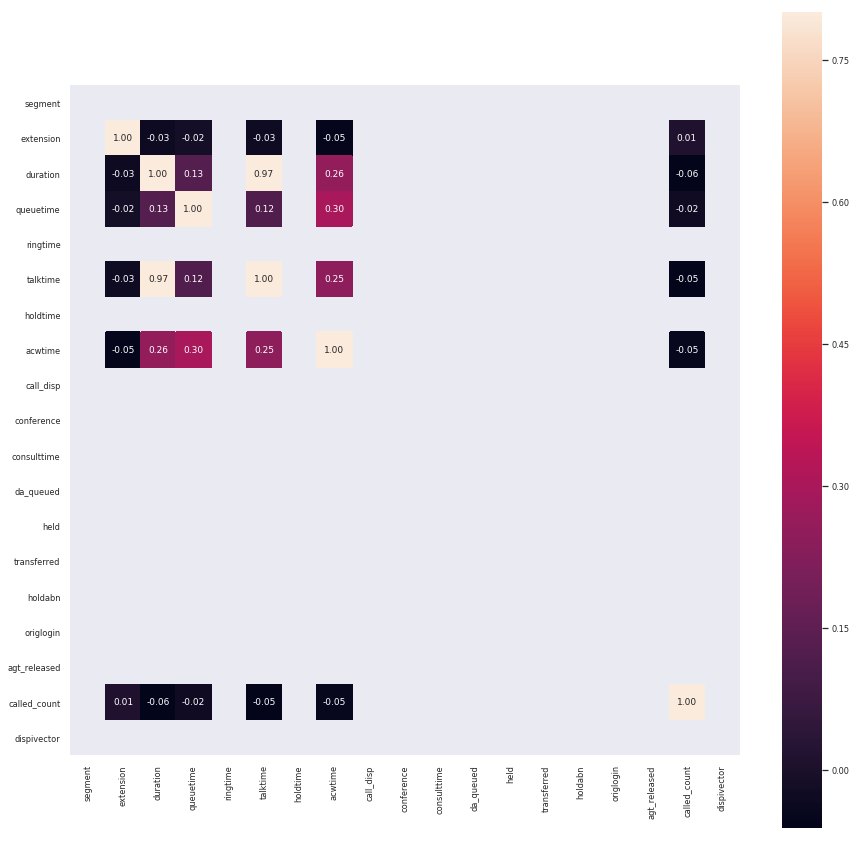

In [244]:
show_heatmap(train.iloc[:, :31])